In [1]:
from datetime import datetime

import matplotlib.pyplot  as plt
import numpy as np
import pandas as pd
import seaborn as sns
from replay.metrics import HitRate, NDCG, Coverage, OfflineMetrics
from replay.preprocessing.filters import MinCountFilter, LowRatingFilter
from replay.splitters.time_splitter import TimeSplitter
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import os
if "HOME" not in os.environ and "USERPROFILE" in os.environ:
    os.environ["HOME"] = os.environ["USERPROFILE"]
    os.environ["HADOOP_HOME"] = r"C:\hadoop"

In [2]:
data = pd.read_csv('interaction_data.csv')
itemdata = pd.read_csv('edadata.csv').drop(columns=['artist_name', 'track_name'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737829 entries, 0 to 737828
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    737829 non-null  int64 
 1   item_id    737829 non-null  int64 
 2   rating     737829 non-null  int64 
 3   timestamp  737829 non-null  object
dtypes: int64(3), object(1)
memory usage: 22.5+ MB


In [3]:
import pandas as pd
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Сортируем по времени
data = data.sort_values('timestamp').reset_index(drop=True)
threshold_time = data['timestamp'].quantile(0.8)

train = data[data['timestamp'] < threshold_time].copy()
test = data[data['timestamp'] >= threshold_time].copy()

print(f"Train size: {len(train)} ({len(train)/len(data):.1%})")
print(f"Test size: {len(test)} ({len(test)/len(data):.1%})")
print(f"Threshold time: {threshold_time}")

# Пользователи и треки, которые есть в train
train_users = set(train['user_id'].unique())
train_items = set(train['item_id'].unique())

test = test[
    (test['user_id'].isin(train_users)) &
    (test['item_id'].isin(train_items))
].copy()

Train size: 590263 (80.0%)
Test size: 147566 (20.0%)
Threshold time: 2025-08-13 23:08:49.570646784


In [4]:
# Сколько айтемов вообще есть?
total_items = itemdata['item_id'].nunique()
interacted_items_count = data['item_id'].nunique()
print(f"Всего треков: {total_items}")
print(f"Покрыто треков: {interacted_items_count} ({100 * interacted_items_count / total_items:.1f}%)")

# Распределение взаимодействий по айтемам
item_counts = data['item_id'].value_counts()
print("Топ-5 самых популярных треков:")
print(item_counts.head())
print("Количество треков с < 5 взаимодействий:", (item_counts < 5).sum())

Всего треков: 4058
Покрыто треков: 4058 (100.0%)
Топ-5 самых популярных треков:
item_id
2105    1051
2102    1046
2104    1034
2101    1032
3941    1029
Name: count, dtype: int64
Количество треков с < 5 взаимодействий: 0


In [5]:
print('Юзеров в train = {}'.format(train.user_id.nunique()))
print('Айтемов в train = {}'.format(train.item_id.nunique()))

Юзеров в train = 5500
Айтемов в train = 4058


In [6]:
train.head()

,user_id,item_id,rating,timestamp
0,5100,3127,4,2024-10-26 00:00:45.557890990
1,4555,3779,2,2024-10-26 00:00:47.360542930
2,3727,1267,3,2024-10-26 00:01:28.131451528
3,586,672,3,2024-10-26 00:02:41.183476935
4,4622,1810,4,2024-10-26 00:04:00.180754255


In [7]:
from src.r_itemkNN import ItemKNN

model = ItemKNN(k_neighbours=10)
model.fit(train)

In [8]:
predict = model.predict(test.user_id.unique())

In [9]:
metrics = [HitRate(topk=10), NDCG(topk=10), Coverage(topk=10)]
OfflineMetrics(metrics, query_column='user_id')(predict, test, train)

{'HitRate@10': 0.4036363636363636,
 'NDCG@10': 0.056817793512584515,
 'Coverage@10': 0.7326269098077871}

<Axes: >

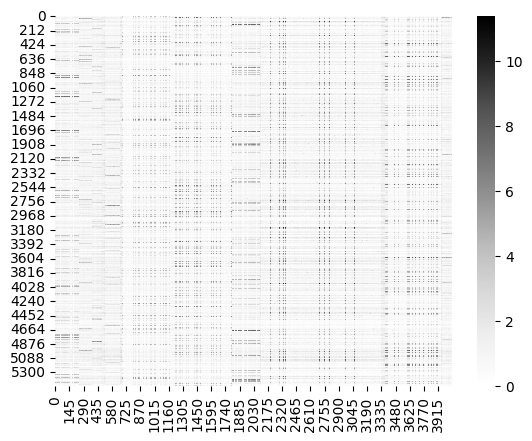

In [10]:
predicted = model.raw_train_matrix @ model.similarity_matrix
sns.heatmap(predicted, cmap='Greys')

In [11]:
import sys

def get_size(obj, seen=None):
    """Рекурсивно оценивает размер объекта в байтах."""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Помечаем объект как уже учтённый
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size


In [12]:
model_size_bytes = get_size(model)
model_size_mb = model_size_bytes / (1024 * 1024)
print(f"Размер модели в памяти: {model_size_mb:.2f} МБ")

Размер модели в памяти: 296.54 МБ


In [ ]:
from src.r_slim import Slim

model = Slim()
model.fit(train)

progress:   0%|          | 0/4058 [00:00<?, ?it/s]

In [ ]:
predict = model.predict(test.user_id.unique())

In [ ]:
metrics = [HitRate(topk=10), NDCG(topk=10), Coverage(topk=10)]
OfflineMetrics(metrics, query_column='user_id')(predict, test, train)

In [ ]:
predicted = model.raw_train_matrix @ model.similarity_matrix
sns.heatmap(predicted, cmap='Greys')